### 本项目为新闻文本分类，利用基于LSTM的TextRNN对十个类别的新闻文本进行分类，实验环境为：Tesla P100

In [1]:
import numpy as np
import time
from tqdm import tqdm
import tensorflow.contrib.keras as kr

import torch 
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [2]:
# 读取分类目录，固定
def read_category():
    categories = ['体育', '财经', '房产', '家居', '教育', '科技', '时尚', '时政', '游戏', '娱乐']
    categories = [x for x in categories]
    cat_to_id = dict(zip(categories, range(len(categories)))) 
    return categories, cat_to_id

In [3]:
categories, cat_to_id = read_category()

In [4]:
# 读取词汇表
def read_vocab(vocab_dir):
    with open(vocab_dir, 'r', encoding='utf-8', errors='ignore') as fp:
        words = [_.strip() for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

In [5]:
words, word_to_id = read_vocab('cnews.vocab.txt')

In [6]:
vocab_size = len(words)
vocab_size

5000

In [7]:
# 将文件转换为id表示
def process_file(filename, word_to_id, cat_to_id, max_length=600):
    contents, labels = [], []
    with open(filename, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            try:
                label, content = line.strip().split('\t')
                if content:
                    contents.append(list(content))
                    labels.append(label)
            except:
                pass
    data_id, label_id = [], []
    for i in range(len(contents)):
        data_id.append([word_to_id[x] for x in contents[i] if x in word_to_id])#将每句话id化 
        label_id.append(cat_to_id[labels[i]])#每句话对应的类别的id
    
    # # 使用keras提供的pad_sequences来将文本pad为固定长度
    x_pad = kr.preprocessing.sequence.pad_sequences(data_id, max_length)
    y_pad = kr.utils.to_categorical(label_id, num_classes=len(cat_to_id))  # 将标签转换为one-hot表示
    #
    return x_pad, y_pad

In [8]:
x_train, y_train = process_file('./cnews.train.txt', word_to_id, cat_to_id)
x_val, y_val = process_file('./cnews.val.txt', word_to_id, cat_to_id)
x_test, y_test = process_file('./cnews.test.txt', word_to_id, cat_to_id)

In [11]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(50000, 600) (50000, 10)
(5000, 600) (5000, 10)
(10000, 600) (10000, 10)


In [12]:
# from_numpy
x_train, y_train = torch.from_numpy(x_train), torch.from_numpy(y_train)
x_val, y_val= torch.from_numpy(x_val), torch.from_numpy(y_val)
x_test, y_test= torch.from_numpy(x_test), torch.from_numpy(y_test)

In [13]:
# 转换LongTensor
x_train, y_train = x_train.type(torch.LongTensor), y_train.type(torch.LongTensor)
x_val, y_val= x_val.type(torch.LongTensor), y_val.type(torch.LongTensor)
x_test, y_test= x_test.type(torch.LongTensor), y_test.type(torch.LongTensor)

In [14]:
# 超参数
Batch_size=512
Learning_rate = 0.01
Epoch=50
Theshold = 10

device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [15]:
# 封装
train = TensorDataset(x_train.to(device), y_train.to(device))
val = TensorDataset(x_val.to(device), y_val.to(device))
test = TensorDataset(x_test.to(device), y_test.to(device))

In [16]:
# 分批
train_loader = DataLoader(train, batch_size=Batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=Batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=Batch_size, shuffle=True)

In [17]:
from model_LSTM import TextRNN
model = TextRNN()
model.to(device)

TextRNN(
  (embedding): Embedding(5000, 128)
  (rnn): LSTM(128, 256, num_layers=2, bidirectional=True)
  (f1): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Dropout(p=0.8, inplace=False)
    (2): ReLU()
  )
  (f2): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [18]:
# 配置训练
optimizer = optim.Adam(model.parameters(), lr=Learning_rate)
criterien = nn.CrossEntropyLoss()

In [19]:
def val(model, val_loader):
    # 验证函数
    with torch.no_grad():
        model.eval()
        loss_counts = 0
        for i,(x,y) in enumerate(val_loader): 
            y_pred = model(x)
            loss = criterien(y_pred, torch.max(y, axis=1).indices)
            loss_counts += loss
        loss_counts /= (i+1)
        return loss_counts

In [20]:
count = 0                            # 计数器，记录val_loss不下降的次数
val_min = float('inf')               # 初始化最小val_loss
 
loss_curse = []                      # 记录train loss
val_loss_curse=[]                    # 记录val loss
val_loss_per_epoch = []

for epoch in range(Epoch):
    start_time = time.time()
    for i,(x,y) in tqdm(enumerate(train_loader)):
        model.train()
        y_pred = model(x)
        loss = criterien(y_pred, torch.max(y, axis=1).indices)
        
        loss_curse.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 验证
        val_loss = val(model, val_loader)
        val_loss_curse.append(val_loss)
        
    
    
    # 每一个epoch,验证一次，看val_loss, 下降则保存模型，若不下降则。。。early_stopping
    val_loss = val(model, val_loader)
    val_loss_per_epoch.append(val_loss)
    
    print('Epoch:', epoch, 'Train_loss:', loss.item(), 'Val_loss:', val_loss.item(), 'Eta:', time.time()-start_time)
    
    if val_loss <= val_min:
        count = 0
        val_min = val_loss
        torch.save(model, str(epoch)+'_Lstm.pt')
    else:
        count += 1
        if count >= Theshold:
            print('Early_stopping on' + str(epoch) + '...')
            torch.save(model, 'Last' + str(epoch) + '_Lstm.pt')
            break
        else:
            continue

0it [00:00, ?it/s]d:\programs\python\python36\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
98it [05:17,  3.24s/it]
0it [00:00, ?it/s]

Epoch: 0 Train_loss: 2.116887092590332 Val_loss: 2.115765333175659 Eta: 320.30424404144287


98it [05:16,  3.23s/it]
0it [00:00, ?it/s]

Epoch: 1 Train_loss: 2.0902795791625977 Val_loss: 2.1036536693573 Eta: 319.34046363830566


98it [05:16,  3.23s/it]
0it [00:00, ?it/s]

Epoch: 2 Train_loss: 2.1007728576660156 Val_loss: 2.1001336574554443 Eta: 319.80886006355286


98it [05:16,  3.23s/it]
0it [00:00, ?it/s]

Epoch: 3 Train_loss: 2.108156442642212 Val_loss: 2.1106765270233154 Eta: 319.44072341918945


98it [05:16,  3.23s/it]
0it [00:00, ?it/s]

Epoch: 4 Train_loss: 2.0712621212005615 Val_loss: 2.1058876514434814 Eta: 319.64994621276855


98it [05:17,  3.24s/it]
0it [00:00, ?it/s]

Epoch: 5 Train_loss: 2.100489377975464 Val_loss: 2.107815980911255 Eta: 319.8712944984436


98it [05:16,  3.23s/it]
0it [00:00, ?it/s]

Epoch: 6 Train_loss: 2.0218071937561035 Val_loss: 2.109494924545288 Eta: 319.4960844516754


98it [05:16,  3.23s/it]
0it [00:00, ?it/s]

Epoch: 7 Train_loss: 2.101105213165283 Val_loss: 2.107860565185547 Eta: 319.71619939804077


98it [05:17,  3.24s/it]
0it [00:00, ?it/s]

Epoch: 8 Train_loss: 2.104611873626709 Val_loss: 2.106818914413452 Eta: 320.1677086353302


98it [05:19,  3.26s/it]
0it [00:00, ?it/s]

Epoch: 9 Train_loss: 2.0502917766571045 Val_loss: 2.1060903072357178 Eta: 322.32800364494324


98it [05:19,  3.26s/it]
0it [00:00, ?it/s]

Epoch: 10 Train_loss: 2.076555013656616 Val_loss: 2.102710723876953 Eta: 322.2515938282013


98it [05:28,  3.36s/it]
0it [00:00, ?it/s]

Epoch: 11 Train_loss: 2.1127536296844482 Val_loss: 2.10030198097229 Eta: 331.67942094802856


98it [05:19,  3.26s/it]


Epoch: 12 Train_loss: 2.070709228515625 Val_loss: 2.1065433025360107 Eta: 321.7263207435608
Early_stopping on12...


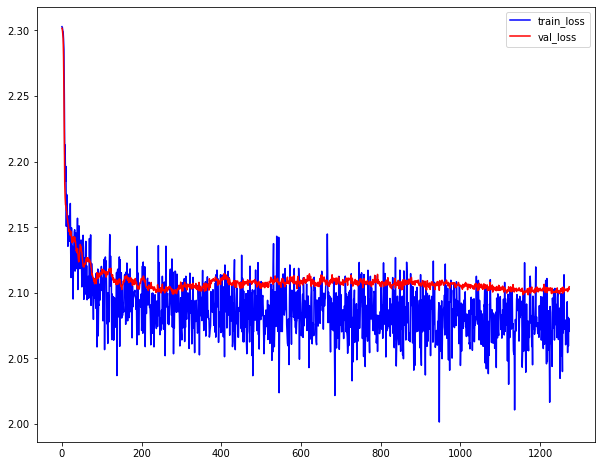

In [24]:
# 绘制学习曲线
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(range(len(loss_curse)), loss_curse, c='b')
plt.plot(range(len(val_loss_curse)), val_loss_curse, c='r')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [22]:
# 测试
with torch.no_grad():
    model = torch.load('Last' + str(epoch) + '_Lstm.pt')
    model.eval()
    
    result = []
    acc = 0
    loss_counts = 0
    for i,(x,y) in enumerate(test_loader): 
        y_pred = model(x)
        y = torch.max(y, axis=1).indices
        loss = criterien(y_pred, y)
        loss_counts += loss.item()
        acc += (torch.max(y_pred.cpu(), axis=1).indices == y.cpu()).sum().numpy() / y.shape[0]
        accuracy = acc/(i+1)
        result.append(y_pred)
    acc /= len(test_loader)
    loss_counts /= len(test_loader)
    print('accuracy',acc)

d:\programs\python\python36\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


accuracy 0.39486443014705885
